# Fraud Detection Using Machine Learning

### Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

### Loading the Dataset

In [2]:
df = pd.read_csv("Fraud.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
# Checking for missing values:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

###### Observation: No missing values were found.

### Exploratory Data Analysis (EDA)

In [5]:
# Checking Class Distribution
print(df['isFraud'].value_counts())

isFraud
0    6354407
1       8213
Name: count, dtype: int64


##### Observation: The dataset is highly imbalanced since majority of transactions are non-fraudulent

In [6]:
#Fraud Count by Transaction Type
fraud_by_type = df.groupby('type')['isFraud'].agg(['sum', 'count'])
print(fraud_by_type)

           sum    count
type                   
CASH_IN      0  1399284
CASH_OUT  4116  2237500
DEBIT        0    41432
PAYMENT      0  2151495
TRANSFER  4097   532909


##### Fraud is mainly seen in CASH_OUT and TRANSFER transactions.

In [7]:
# Feature Engineering
df['emptied_account'] = (df['newbalanceOrig'] == 0).astype(int)
df['balance_diff'] = df['oldbalanceOrg'] - df['amount']
df['new_account_dest'] = df['oldbalanceDest'] == 0

# Fraudsters often empty accounts after transactions.
# New accounts may indicate suspicious activities.

### Data Preprocessing and Handling Imbalance

In [8]:
# Filtering Relevant Transactions
df_filtered = df[(df['type'] == 'CASH_OUT') | (df['type'] == 'TRANSFER')]
df_filtered = df_filtered.drop(columns=['nameOrig', 'nameDest', 'step', 'type'])

# Handling Imbalanced Data with SMOTE (Synthetic Minority Oversampling Technique)
X = df_filtered.drop(columns=['isFraud'])
y = df_filtered['isFraud']
# Splitting into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Applying SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# Class distribution after SMOTE
print(y_train_resampled.value_counts())

isFraud
0    1933569
1    1933569
Name: count, dtype: int64


### Model Training & Evaluation

##### Logistic Regression Model

In [9]:
model = LogisticRegression(max_iter=500)
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)

# Model evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9318969635060034

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96    828627
           1       0.04      0.91      0.07      2496

    accuracy                           0.93    831123
   macro avg       0.52      0.92      0.52    831123
weighted avg       1.00      0.93      0.96    831123


Confusion Matrix:
 [[772242  56385]
 [   217   2279]]


##### Random Forest Model (Tuned)

In [10]:
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42, n_jobs=-1)
rf_model.fit(X_train_resampled, y_train_resampled)

y_pred_rf = rf_model.predict(X_test)

# Model Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Accuracy: 0.9998724617174594

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    828627
           1       0.96      1.00      0.98      2496

    accuracy                           1.00    831123
   macro avg       0.98      1.00      0.99    831123
weighted avg       1.00      1.00      1.00    831123


Confusion Matrix:
 [[828530     97]
 [     9   2487]]


### Feature Importance Analysis

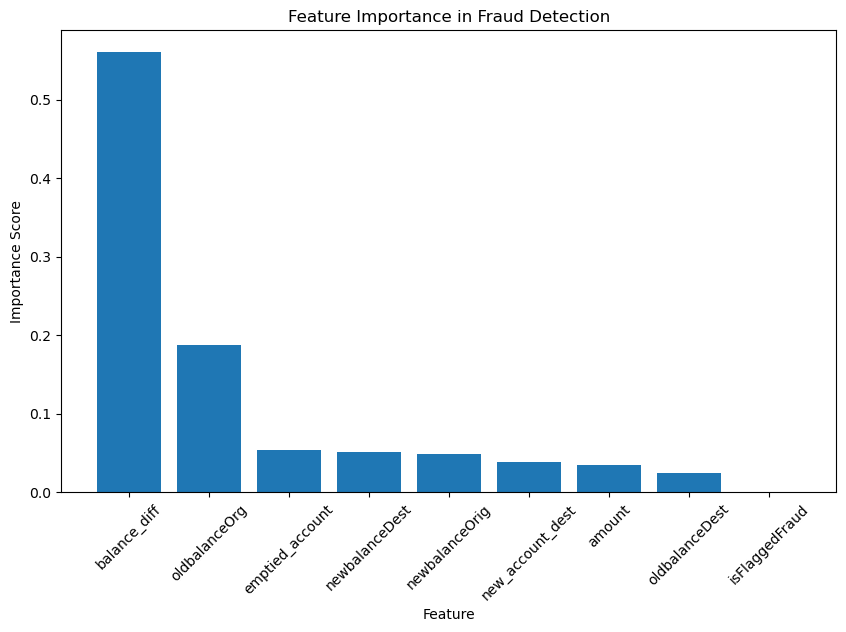

In [15]:
# Extract feature importance
feature_importances = rf_model.feature_importances_
features = X_train_resampled.columns

# Sort feature importance
sorted_indices = np.argsort(feature_importances)[::-1]

# Plot feature importance
plt.figure(figsize=(10,6))
plt.bar(range(len(features)), feature_importances[sorted_indices], align="center")
plt.xticks(range(len(features)), np.array(features)[sorted_indices], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Feature Importance in Fraud Detection")
plt.show()

##### Observations:

The difference between the sender’s old and new balance is the most important factor in detecting fraud, showing that fraudsters often empty accounts.

The sender’s initial balance also plays an important role, as high-balance accounts are more likely to be targeted.

The transaction amount and receiver’s final balance have moderate influence, while the system’s fraud flagging mechanism is the least effective in identifying fraud.